In [ ]:
#pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner
#pip install scikeras

In [1]:
from imblearn.over_sampling import SMOTE
from keras import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras_tuner.tuners import GridSearch
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf

In [2]:
# Read data
df = pd.read_csv('dataset_phishing.csv')

In [3]:
features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags', 'nb_hyphens', 'page_rank', 'avg_word_path', 'ratio_extHyperlinks',
 'longest_words_raw', 'google_index', 'length_hostname', 'longest_word_host', 'domain_registration_length', 'nb_www', 'nb_underscore', 'nb_dots',
 'ratio_extMedia', 'phish_hints', 'domain_in_title', 'web_traffic', 'safe_anchor', 'nb_space', 'shortening_service', 'ip', 'domain_age', 'nb_qm',
 'nb_hyperlinks', 'nb_slash']

In [4]:
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df["status"])

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# MLP

# Handle class imbalance by oversampling the minority class (phishing)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.15)

# Set up hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(200, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.008]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Get the best model from the grid search
best_mlp = grid_search.best_estimator_

# Evaluate the model on the validation set
mlp_y_pred = best_mlp.predict(X_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [6]:
#CNN
# Define a seed value for reproducibility
seed = 42

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

def create_model(filters_1=32, kernel_size_1=3, dropout_rate_1=0.2,
                 filters_2=64, kernel_size_2=3, dropout_rate_2=0.2,
                 dense_units=128, learning_rate=0.001):
    model = Sequential()
    
    # First Conv1D layer
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size_1,
                     activation='relu', input_shape=(X_train_cnn.shape[1], 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_1))
    
    # Second Conv1D layer
    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size_2,
                     activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_2))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Recall()])
    
    return model

In [7]:
X = df[features]
y = df['status']

# Map the 'status' to numerical labels
label_mapping = {'legitimate': 0, 'phishing': 1}
y = y.map(label_mapping)

# Handle missing values in features if any
X.fillna(0, inplace=True)

# Reshape the data
X_reshaped = X.values

# Perform the split as specified
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)


best_params = {'dense_units': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'filters_1': 32, 'filters_2': 64, 'kernel_size_1': 3, 'kernel_size_2': 2, 'learning_rate': 0.01}

# Create and train the model with best parameters
print("\nTraining final model with best parameters...")
best_cnn = create_model(**best_params)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_recall', patience=5, 
                             restore_best_weights=True, mode='max')

# Train the model
history = best_cnn.fit(
    X_train_cnn, y_train,
    epochs=50,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Training final model with best parameters...
Epoch 1/50


/var/folders/ss/kwxwfq350cqd6j60p6ssx2xc0000gn/T/ipykernel_87113/369168224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)
/Users/teckyew/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8991 - loss: 0.2734 - recall: 0.8860 - val_accuracy: 0.8856 - val_loss: 0.2879 - val_recall: 0.7865
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9315 - loss: 0.1915 - recall: 0.9215 - val_accuracy: 0.9405 - val_loss: 0.1607 - val_recall: 0.9382
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9368 - loss: 0.1750 - recall: 0.9317 - val_accuracy: 0.9376 - val_loss: 0.1687 - val_recall: 0.9475
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9396 - loss: 0.1720 - recall: 0.9404 - val_accuracy: 0.9434 - val_loss: 0.1510 - val_recall: 0.9347
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9416 - loss: 0.1563 - recall: 0.9395 - val_accuracy: 0.9422 - val_loss: 0.1519 - val_recall: 0.9405
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9435 - loss: 0.1500 - recall: 0.9404 - val_accuracy: 0.9481 - val_loss: 0.1508 - val_recall: 0.9440
Epoch 7/50
251/

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9389 - loss: 0.1569 - recall: 0.9390

Test Metrics:
--------------------
Test Accuracy : 0.9417
Test Recall   : 0.9440
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Detailed Model Performance Metrics:
----------------------------------------
Accuracy      : 0.9417
Precision     : 0.9396
Recall        : 0.9440
F1 Score      : 0.9418

Confusion Matrix:
--------------------
[[806  52]
 [ 48 809]]

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       858
           1       0.94      0.94      0.94       857

    accuracy                           0.94      1715
   macro avg       0.94      0.94      0.94      1715
weighted avg       0.94      0.94      0.94      1715



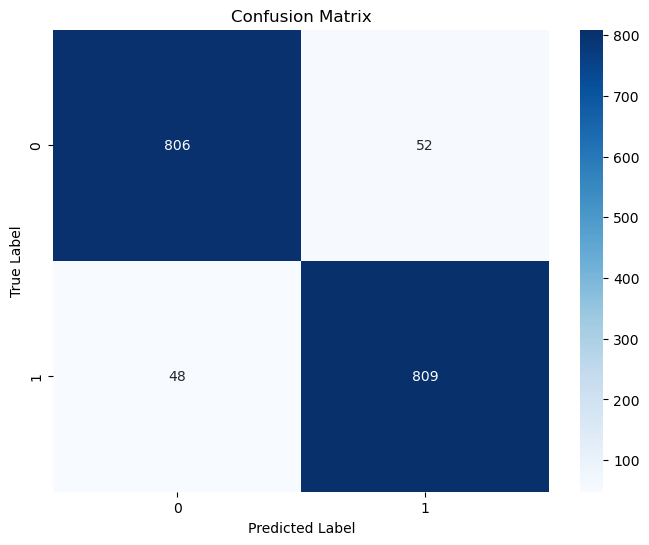

In [8]:
# Evaluate the model on test data
test_loss, test_acc, test_recall = best_cnn.evaluate(X_test_cnn, y_test)
print('\nTest Metrics:')
print('-' * 20)
print('Test Accuracy : {:.4f}'.format(test_acc))
print('Test Recall   : {:.4f}'.format(test_recall))

# Predict probabilities and classes
y_pred_proba = best_cnn.predict(X_test_cnn).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nDetailed Model Performance Metrics:')
print('-' * 40)
print('Accuracy      : {:.4f}'.format(accuracy))
print('Precision     : {:.4f}'.format(precision))
print('Recall        : {:.4f}'.format(recall))
print('F1 Score      : {:.4f}'.format(f1))

# Print confusion matrix
print('\nConfusion Matrix:')
print('-' * 20)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Print detailed classification report
print('\nClassification Report:')
print('-' * 40)
print(classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
#LSTM
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

#Reshape features with 1 timestep to fit into RNN
X_reshaped = X_scaled.reshape((X.shape[0],1,X.shape[1]))  

le = LabelEncoder()
y = le.fit_transform(df["status"])
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#Define model to fir into GridSearch later
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Choice('units',[128,512,1024,2048]), activation=hp.Choice('activation',['relu','tanh']),input_shape=(1,X.shape[1]))) #4 Different layer sizes
    model.add(Dropout(hp.Float('dropout',0.1,0.5,step=0.1))) #5 different dropout values
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

best_lstm = Sequential()
best_lstm.add(LSTM(1024, activation='relu',input_shape=(1,X.shape[1]))) 
best_lstm.add(Dropout(0.1))
best_lstm.add(Dense(1, activation='sigmoid'))
best_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = best_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val,y_val))

y_pred = (best_lstm.predict(X_test) > 0.5)

print(f"Accuracy: {accuracy_score(y_test,y_pred):.4f}")
print(f"Precision: {precision_score(y_test,y_pred):.4f}")
print(f"Recall:  {recall_score(y_test,y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test,y_pred):.4f}")
print(f"ROC_AUC Score: {roc_auc_score(y_test,y_pred):.4f}")
print(classification_report(y_test, y_pred))

/Users/teckyew/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9109 - loss: 0.3214 - val_accuracy: 0.9452 - val_loss: 0.1545
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9444 - loss: 0.1454 - val_accuracy: 0.9463 - val_loss: 0.1436
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9518 - loss: 0.1277 - val_accuracy: 0.9510 - val_loss: 0.1370
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9555 - loss: 0.1169 - val_accuracy: 0.9516 - val_loss: 0.1337
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9589 - loss: 0.1100 - val_accuracy: 0.9539 - val_loss: 0.1308
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9650
Precision: 0.9672
Recall:  0.9627
F1 Score: 0.9649
ROC_AUC Score: 0.9650
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       858
           1       0.97      0.96      0.96       857

    accuracy                           0.97      1715
   macro avg 

In [ ]:
# Start of ensemble model (Stacking)

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)

# Load your trained models
mlp_model = best_mlp  # Use your trained MLP model
cnn_model = best_cnn
lstm_model = best_lstm

# Read data
df = pd.read_csv('dataset_phishing.csv')
features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags', 'nb_hyphens', 
            'page_rank', 'avg_word_path', 'ratio_extHyperlinks', 'longest_words_raw', 
            'google_index', 'length_hostname', 'longest_word_host', 
            'domain_registration_length', 'nb_www', 'nb_underscore', 
            'nb_dots', 'ratio_extMedia', 'phish_hints', 
            'domain_in_title', 'web_traffic', 'safe_anchor', 
            'nb_space', 'shortening_service', 'ip', 'domain_age', 
            'nb_qm', 'nb_hyperlinks', 'nb_slash']

X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df["status"])

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape data for CNN and LSTM
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))  
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Get predictions from each model
mlp_predictions_train = mlp_model.predict(X_train)
mlp_predictions_val = mlp_model.predict(X_val)
mlp_predictions_test = mlp_model.predict(X_test)

cnn_predictions_train = cnn_model.predict(X_train_cnn)
cnn_predictions_val = cnn_model.predict(X_val_cnn)
cnn_predictions_test = cnn_model.predict(X_test_cnn)

lstm_predictions_train = lstm_model.predict(X_train_lstm)
lstm_predictions_val = lstm_model.predict(X_val_lstm)
lstm_predictions_test = lstm_model.predict(X_test_lstm)

# Stack predictions into a new feature set for the final estimator
X_train_stacked = np.column_stack((mlp_predictions_train, cnn_predictions_train, lstm_predictions_train))
X_val_stacked = np.column_stack((mlp_predictions_val, cnn_predictions_val, lstm_predictions_val))
X_test_stacked = np.column_stack((mlp_predictions_test, cnn_predictions_test, lstm_predictions_test))

# Train a final estimator using the stacked predictions
final_estimator = LogisticRegression(random_state=42)

# Fit the final estimator
final_estimator.fit(X_train_stacked, y_train)

# Make predictions on the validation and test sets
stacked_predictions_val = final_estimator.predict(X_val_stacked)
stacked_predictions_test = final_estimator.predict(X_test_stacked)

# Calculate performance metrics on the validation set
accuracy_val = accuracy_score(y_val, stacked_predictions_val)
precision_val = precision_score(y_val, stacked_predictions_val)
recall_val = recall_score(y_val, stacked_predictions_val)
f1_val = f1_score(y_val, stacked_predictions_val)
stacked_probabilities_val = final_estimator.predict_proba(X_val_stacked)
auc_val = roc_auc_score(y_val, stacked_probabilities_val[:, 1])

# Calculate performance metrics on the test set
accuracy_test = accuracy_score(y_test, stacked_predictions_test)
precision_test = precision_score(y_test, stacked_predictions_test)
recall_test = recall_score(y_test, stacked_predictions_test)
f1_test = f1_score(y_test, stacked_predictions_test)
stacked_probabilities_test = final_estimator.predict_proba(X_test_stacked)
auc_test = roc_auc_score(y_test, stacked_probabilities_test[:, 1])

# Print performance metrics
print("\nPerformance Metrics for Stacked Model on Validation Set:")
print(f"Accuracy       : {accuracy_val:.4f}")
print(f"Precision      : {precision_val:.4f}")
print(f"Recall         : {recall_val:.4f}")
print(f"F1 Score       : {f1_val:.4f}")
print(f"AUC            : {auc_val:.4f}")

print("\nPerformance Metrics for Stacked Model on Test Set:")
print(f"Accuracy       : {accuracy_test:.4f}")
print(f"Precision      : {precision_test:.4f}")
print(f"Recall         : {recall_test:.4f}")
print(f"F1 Score       : {f1_test:.4f}")
print(f"AUC            : {auc_test:.4f}")


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Performance Metrics for Stacked Model on Validation Set:
Accuracy       : 0.9516
Precision      : 0.9397
Recall         : 0.9631
F1 Score       : 0.9513
AUC            : 0.9896

Performance Metrics for Stacked Model on Test Set:
Accuracy       : 0.9598
Precision      : 0.9589
Recall         : 0.9622
F1 Score       : 0.9605
AUC            : 0.9900
